In [253]:
%config IPCompleter.greedy=True
%matplotlib inline

In [254]:
import spotipy.util as util
import spotipy
import requests
import matplotlib.pyplot as plt
import socket
import array
import os
import dotenv
import time
from bisect import bisect_left

In [255]:
dotenv.load_dotenv(".env")
user_id = os.environ['USER_ID']
client_id = os.environ['CLIENT_ID']
client_secret = os.environ['CLIENT_SECRET']
scope = 'user-read-currently-playing,user-read-playback-state'

In [256]:
token = util.prompt_for_user_token(user_id, scope,
                                   client_id=client_id,
                                   client_secret=client_secret,
                                   redirect_uri='http://localhost:8000/')

In [257]:
sp = spotipy.Spotify(auth=token)

In [258]:
current_playing = sp._get('me/player/currently-playing')

In [259]:
current_playing['item']['artists'][0]['name'], current_playing['item']['name']

('David Gilmour', 'Red Sky at Night')

In [260]:
analysis = sp._get('audio-analysis/' + current_playing['item']['id'])

In [261]:
analysis['bars'][:2]

[{'start': 0.84832, 'duration': 1.45875, 'confidence': 0.746},
 {'start': 2.30707, 'duration': 1.43216, 'confidence': 0.655}]

In [262]:
analysis['beats'][:2]

[{'start': 0.34949, 'duration': 0.49882, 'confidence': 0.191},
 {'start': 0.84832, 'duration': 0.48799, 'confidence': 0.15}]

In [263]:
analysis['segments'][:1]

[{'start': 0.0,
  'duration': 0.1156,
  'confidence': 0.0,
  'loudness_start': -45.811,
  'loudness_max_time': 0.00861,
  'loudness_max': -43.234,
  'loudness_end': 0.0,
  'pitches': [1.0,
   0.551,
   0.255,
   0.326,
   0.653,
   0.607,
   0.26,
   0.269,
   0.369,
   0.164,
   0.066,
   0.387],
  'timbre': [15.44,
   -69.816,
   -8.182,
   -19.37,
   55.445,
   -51.875,
   20.676,
   15.851,
   -47.835,
   -8.084,
   -4.357,
   0.437]}]

In [264]:
analysis['sections'][:2]

[{'start': 0.0,
  'duration': 11.36445,
  'confidence': 1.0,
  'loudness': -28.148,
  'tempo': 125.451,
  'tempo_confidence': 0.131,
  'key': 1,
  'key_confidence': 0.0,
  'mode': 1,
  'mode_confidence': 0.0,
  'time_signature': 4,
  'time_signature_confidence': 0.562},
 {'start': 11.36445,
  'duration': 31.41322,
  'confidence': 1.0,
  'loudness': -12.292,
  'tempo': 126.013,
  'tempo_confidence': 0.177,
  'key': 5,
  'key_confidence': 0.012,
  'mode': 0,
  'mode_confidence': 0.535,
  'time_signature': 3,
  'time_signature_confidence': 0.951}]

In [265]:
analysis['tatums'][:2]

[{'start': 0.34949, 'duration': 0.33255, 'confidence': 0.191},
 {'start': 0.68204, 'duration': 0.16627, 'confidence': 0.191}]

## gantt of blocks

In [266]:
names = ('bars', 'beats', 'sections', 'segments', 'tatums')

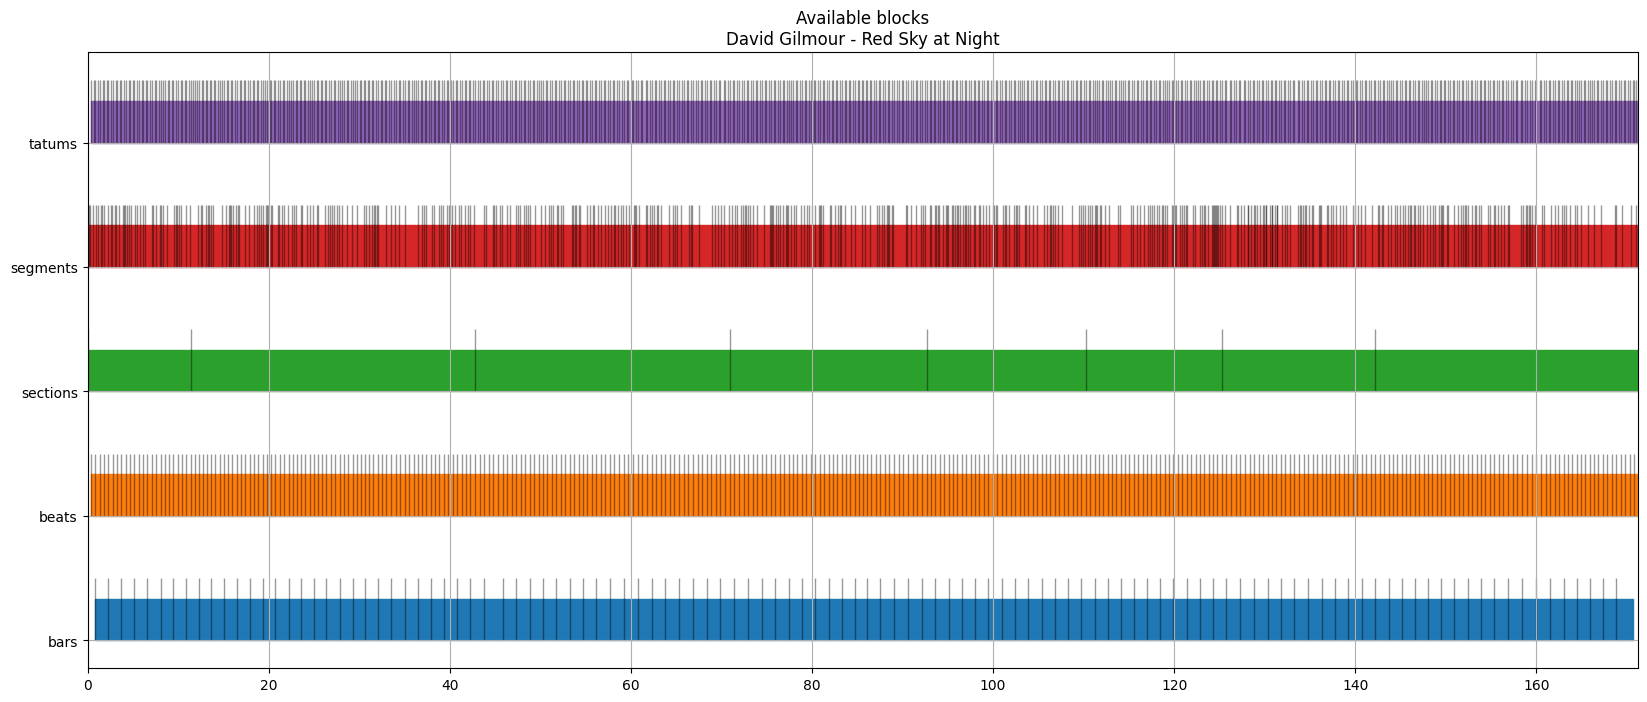

In [267]:
fig, ax = plt.subplots(figsize=(20, 8)) 
ax.set_xlim(0, current_playing['item']['duration_ms'] / 1000)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.title('Available blocks\n' + current_playing['item']['artists'][0]['name'] + ' - ' + current_playing['item']['name'])
ax.grid(True)
for n, name in enumerate(names):
    ax.broken_barh(
        [(x['start'], x['duration']) for x in analysis[name]],
        (3 * n, 1), color=colors[n])
    ax.broken_barh(
        [(x['start'], 0.0001) for x in analysis[name]],
        (3 * n, 1.5), color='black', alpha=0.4)

ax.set_yticks(range(0, 3 * len(names), 3))
ax.set_yticklabels(names)
pass

## Colors

In [268]:
SCALE = (255, 255, 255)
BASE_COLOR_MULTIPLIER = 100
LOUDNESS_MULTIPLIER = 1.5

from typing import List, Tuple, Callable, Dict, Any

# Shared communication
RawSpotifyResponse = Dict[str, Any]
Colors = List[Tuple[int, int, int]]


def _normalize(pv: float) -> float:
    if pv < 0:
        return 0.
    elif pv > 255:
        return 255.
    else:
        return pv


_scale_pixel = lambda p: (int(_normalize(p[0]) * SCALE[0] / 255),
                          int(_normalize(p[1]) * SCALE[1] / 255),
                          int(_normalize(p[2]) * SCALE[2] / 255))


In [269]:
def make_get_current_colors(analysis: RawSpotifyResponse, leds: int) -> Callable[[float], Colors]:
    def make_get_current(name):
        keys = [x['start'] for x in analysis[name]]
        key_to_x = {x['start']: x for x in analysis[name]}
        return lambda t: key_to_x[keys[bisect_left(keys, t) - 1]]

    get_current_segmnet = make_get_current('segments')
    get_current_section = make_get_current('sections')
    get_current_beat = make_get_current('beats')

    def make_scale(name):
        xs = [x[name] for x in analysis['sections']]
        min_xs = min(xs)
        max_xs = max(xs)
        return lambda x: (x - min_xs) / (max_xs - min_xs)

    scale_loudness = make_scale('loudness')
    scale_tempo = make_scale('tempo')

    def get_current_colors(t):
        segment = get_current_segmnet(t)
        section = get_current_section(t)
        beat = get_current_beat(t)

        beat_color = BASE_COLOR_MULTIPLIER * (t - beat['start'] + beat['duration']) / beat['duration']
        tempo_color = BASE_COLOR_MULTIPLIER * scale_tempo(section['tempo'])
        pitch_colors = [BASE_COLOR_MULTIPLIER * p for p in segment['pitches']]

        loudness_multiplier = 1 + LOUDNESS_MULTIPLIER * scale_loudness(section['loudness'])

        colors = ((beat_color * loudness_multiplier,
                   tempo_color * loudness_multiplier,
                   pitch_colors[n // (leds // 12)] * loudness_multiplier)
                  for n in range(leds))

        if section['mode'] == 0:
            order = (0, 1, 2)
        elif section['mode'] == 1:
            order = (1, 2, 0)
        else:
            order = (2, 0, 1)

        ordered_colors = ((color[order[0]], color[order[1]], color[order[2]])
                          for color in colors)

        return [_scale_pixel(color) for color in ordered_colors]

    return get_current_colors


In [270]:
def test():
    current_playing = sp._get('me/player/currently-playing')
    analysis = sp._get('audio-analysis/' + current_playing['item']['id'])
    fig, ax = plt.subplots(figsize=(20, 8)) 
    ax.set_xlim(0, current_playing['item']['duration_ms'] / 1000)
    get_current_colors = make_get_current_colors(analysis, 60)
    plt.title('Leds over time\n' + current_playing['item']['artists'][0]['name'] + ' - ' + current_playing['item']['name'])
    for t in range(0, int(current_playing['item']['duration_ms'] / 1000)):
        for n, led in enumerate(get_current_colors(t)):
            plt.broken_barh([(t, 1)], (n, 1), color=(led[0] / 255, led[1] / 255, led[2] / 255))


    plt.tight_layout()

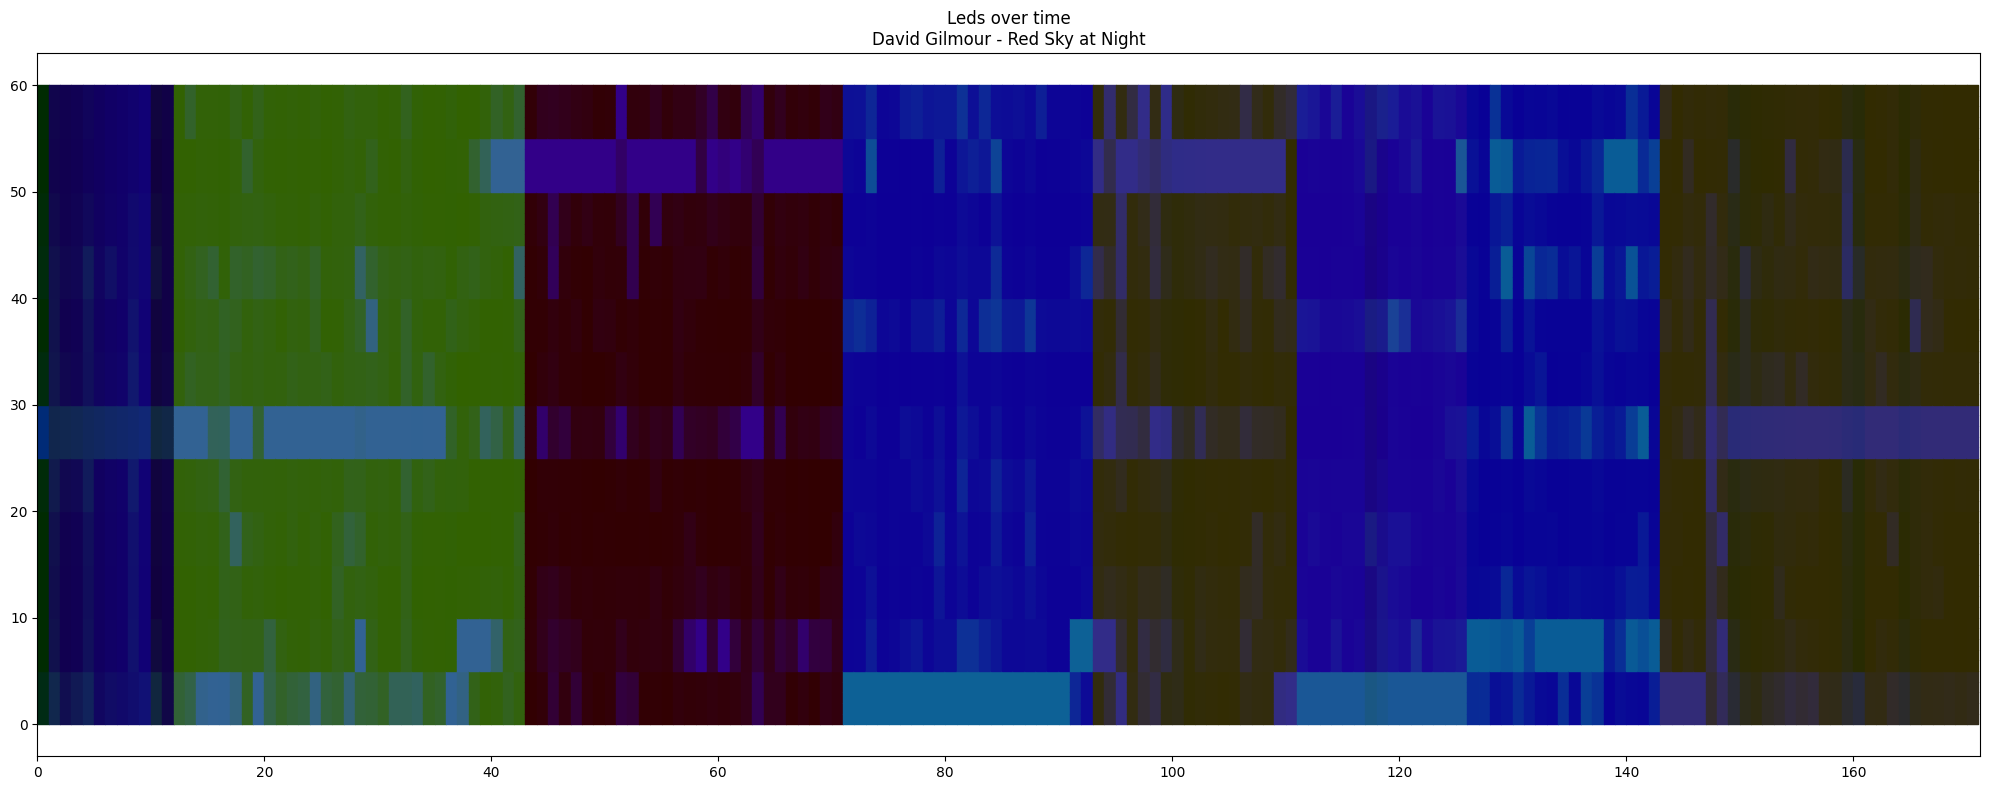

In [271]:
test()